In [10]:
import pickle
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import scipy as sp
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from IPython.display import Image

# Load data

In [2]:
tfidf = pickle.load(open('quora_tfidf.pickle', 'rb'))['tfidf_matrix']
train = pickle.load(open('quora_questions_train_features.pickle', 'rb'))
test = pickle.load(open('quora_questions_test_features.pickle', 'rb'))

# Reduce TF-IDF dimensions
Reference: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [3]:
svd = TruncatedSVD(n_components=100, n_iter=25, random_state=0)
reduced_tfidf = svd.fit_transform(tfidf)

# Add reduced TF-IDF to train and test

In [4]:
df_reduced_tfidf = pd.DataFrame(reduced_tfidf)

q2_reduced_tfidf_col = {}
for i in range(0, 100):
    q2_reduced_tfidf_col[i] = i + 100

df_reduced_tfidf_train_question1 = df_reduced_tfidf.iloc[::2][: len(train)].reset_index(drop=True)
df_reduced_tfidf_train_question2 = df_reduced_tfidf.iloc[1::2][: len(train)].rename(columns=q2_reduced_tfidf_col).reset_index(drop=True)
df_reduced_tfidf_test_question1 = df_reduced_tfidf.iloc[::2][len(train):].reset_index(drop=True)
df_reduced_tfidf_test_question2 = df_reduced_tfidf.iloc[1::2][len(train):].rename(columns=q2_reduced_tfidf_col).reset_index(drop=True)

train = pd.merge(train, df_reduced_tfidf_train_question1, left_index=True, right_index=True)
train = pd.merge(train, df_reduced_tfidf_train_question2, left_index=True, right_index=True)
test = pd.merge(test, df_reduced_tfidf_test_question1, left_index=True, right_index=True)
test = pd.merge(test, df_reduced_tfidf_test_question2, left_index=True, right_index=True)

## Save data for future use

In [17]:
pickle.dump(train, open('quora_questions_train_features_v2.pickle', 'wb'))
pickle.dump(test[: 500000], open('quora_questions_test_features_v2_part1.pickle', 'wb'))
pickle.dump(test[500000: 1000000], open('quora_questions_test_features_v2_part2.pickle', 'wb'))
pickle.dump(test[1000000: 1500000], open('quora_questions_test_features_v2_part3.pickle', 'wb'))
pickle.dump(test[1500000: 2000000], open('quora_questions_test_features_v2_part4.pickle', 'wb'))
pickle.dump(test[2000000:], open('quora_questions_test_features_v2_part5.pickle', 'wb'))

# Prep data for training and prediction

In [18]:
features = ['cosine_sim', 'all_tokens_count', 'common_tokens_count', 'common_tokens_ratio', 
            'char_count_question1', 'char_count_question2', 'ratio_char_count',  
            'token_count_question1', 'token_count_question2', 'ratio_token_count', 
            'common_tokens_count_question1', 'common_tokens_count_question2', 
            'common_tokens_ratio_question1', 'common_tokens_ratio_question2', 
            'ratio_common_tokens_ratio'] + list(range(0, 200))
train_X = train[features]
train_y = train['is_duplicate']
test_X = test[features]

# Log loss function

In [6]:
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

# Logistic Regression

In [7]:
logistic = LogisticRegression()
logistic.fit(train_X, train_y)
test_y_logistic = logistic.predict_proba(test_X)[:, 1]
pred_logistic = pd.merge(test, pd.DataFrame(test_y_logistic).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_logistic[['test_id', 'is_duplicate']].to_csv('submit_14.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], logistic.predict_proba(train_X)[:, 1]))

log loss on train data: 0.485651583769


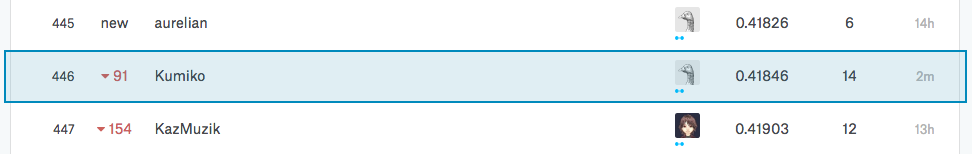

In [9]:
Image(filename='Screen Shot 2017-03-27 at 9.07.24 PM.png')

# XGBoost

In [11]:
xgb_train = xgb.DMatrix(train_X, label=train_y)
xgb_test = xgb.DMatrix(test_X)

params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
xgboost = xgb.train(params, xgb_train)
test_y_xgboost = xgboost.predict(xgb_test)
pred_xgboost = pd.merge(test, pd.DataFrame(test_y_xgboost).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_xgboost[['test_id', 'is_duplicate']].to_csv('submit_15.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], xgboost.predict(xgb_train)))

log loss on train data: 0.468440296367


Log loss on test data: 0.42748